In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cpu device


In [3]:
decaymodes = ['rhorho', 'a1rho', 'a1a1']
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

########### Change this to according dir to download data #######################
parser.add_argument("-i", "--input", dest="IN", default='/home/anderson/higgs_data/rhorho')

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

######Change this to according type (rhorho, a1rho, a1a1)#######################
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_rhorho')

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=True)
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default='/home/anderson/Ztt_raw/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
parser.add_argument("--label", dest="LABEL", default=True)

args, unknown = parser.parse_known_args()


### Converting bkgd raw data into npy

In [4]:
#convert_bkgd_raw(args.BKGDPATH)

0it [00:00, ?it/s]

Failed to convert Ztt raw data for a1a1 :(


0it [00:00, ?it/s]

Failed to convert Ztt raw data for a1rho :(


  0%|          | 0/10 [00:00<?, ?it/s]

Ztt raw data already converted into npy file :)


### Preprocessing signal and bkgd from all the decaymodes

In [5]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
    for decaymode in tqdm(decaymodes):
        points = []
        args.IN = '/home/anderson/higgs_data/'+decaymode
        args.TYPE = 'nn_'+decaymode
        args.Z_FRACTION = 0.5
        data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
        event = eval(events[args.TYPE])(data, args)
        points.append(EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED))
        pickle.dump(points,open(args.IN+'/events_w_background_train.pk','wb'))
        break

  0%|          | 0/3 [00:00<?, ?it/s]

Loading data
Read 1000000 events
Events including background: 1500000
SCALE!!


In [6]:
# position={'nn_rhorho':[0,1,4,5,6,7], 'nn_a1rho':[0,1,2,3,5,6,7], 'nn_a1a1':[0,1,2,3,5,6,8,9]}

### Loading signal samples

In [7]:
points=pickle.load(open(args.IN+'/events_w_background_train.pk','rb'))

### Training NN

In [8]:
batch_size=512

In [9]:
# initializing the training dataset
class MyDataset(Dataset):
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        
        self.rhorho_labels_mc = torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true = torch.from_numpy(rhorho_labels_true).float().to(device)
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [11]:
particle_idx = 0 # decay mode: rhorho

mc_train_idx=np.random.choice(np.arange(points[particle_idx].train.x.shape[0]),int(points[particle_idx].train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points[particle_idx].train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points[particle_idx].valid.x.shape[0]),int(points[particle_idx].valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points[particle_idx].valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points[particle_idx].test.x.shape[0]),int(points[particle_idx].test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points[particle_idx].test.x.shape[0]))-set(mc_train_idx))

In [12]:
uncertainty = 0.0

train_datasets = MyDataset(points[particle_idx].train.x[mc_train_idx], 
                           points[particle_idx].train.x[true_train_idx] + uncertainty*np.random.normal(0,1,size=points[particle_idx].train.x[true_train_idx].shape),
                           points[particle_idx].train.weights[mc_train_idx],
                           points[particle_idx].train.weights[true_train_idx])
train_loader = DataLoader(dataset = train_datasets, batch_size = batch_size, shuffle = True)


valid_datasets = MyDataset(points[particle_idx].valid.x[mc_valid_idx], 
                           points[particle_idx].valid.x[true_valid_idx] + uncertainty*np.random.normal(0,1,size=points[particle_idx].valid.x[true_valid_idx].shape),
                           points[particle_idx].valid.weights[mc_valid_idx],
                           points[particle_idx].valid.weights[true_valid_idx])
valid_loader = DataLoader(dataset = valid_datasets,batch_size = batch_size,shuffle = True)


test_datasets = MyDataset(points[particle_idx].test.x[mc_test_idx], 
                          points[particle_idx].test.x[true_test_idx] + uncertainty*np.random.normal(0,1,size=points[particle_idx].test.x[true_test_idx].shape),
                          points[particle_idx].test.weights[mc_test_idx],
                          points[particle_idx].test.weights[true_test_idx])
test_loader = DataLoader(dataset = test_datasets,batch_size = batch_size,shuffle = True)

In [124]:
model = NeuralNetwork(num_features = points[particle_idx].train.x.shape[1], num_classes = args.NUM_CLASSES+1, num_layers=args.LAYERS, drop_prob=0).to(device)
    
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()
#early_stopping = EarlyStopping(patience=5, verbose=True,path='model/best_model.pt')

In [126]:
epoch=60
training_loss=[]
validation_loss=[]
for i in range(epoch):
    model.train()
    train_loss,sample_numbers,acc,total_samples,bg_acc=0,0,0,0,0
    for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader):
        
        opt_g.zero_grad()
        rhorho_s=rhorho_s[label_s.sum(axis=1)!=0]
        label_s=label_s[label_s.sum(axis=1)!=0]
        outputs=model(rhorho_s)
        if isinstance(criterion,nn.CrossEntropyLoss):
            loss=criterion(outputs,torch.argmax(label_s,axis=1))
            _, predictions = torch.max(outputs, 1)
            acc+=(predictions==torch.argmax(label_s,axis=1)).sum().item()
        else:
            loss=criterion(outputs,label_s)
        loss.backward()
        train_loss+=loss.item()*len(rhorho_s)
        sample_numbers+=len(rhorho_s)
        opt_g.step()
        print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/sample_numbers,acc/sample_numbers),end='')
    training_loss.append(train_loss/sample_numbers)
    print()
    valid_loss,valid_acc,valid_numbers,total_samples,bg_acc=0,0,0,0,0
    model.eval()
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader):
            total_samples+=len(rhorho_t)
            rhorho_t = rhorho_t[label_t.sum(axis=1)!=0]
            label_t = label_t[label_t.sum(axis=1)!=0]
            outputs = model(rhorho_t)
            _, predictions = torch.max(outputs, 1)
            valid_acc += (predictions==torch.argmax(label_t,axis=1)).sum().item()
            valid_loss+=loss.item()*len(rhorho_t)
            valid_numbers += len(rhorho_t)
            print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
    validation_loss.append(valid_loss/valid_numbers)
    print()
    
    if(i%10==9):
        path_name='model/best_model_' + str(i) + '.pt'
        torch.save(model.state_dict(), path_name)
        print('Model saved!')
    print()
    #early_stopping(valid_loss/valid_numbers,model)
    #print()
    #if early_stopping.early_stop:
    #    print("Early stopping")
    #    break;

# test_loss=0
# with torch.no_grad():
#     for inputs, label in test_loader:
#         outputs=model(inputs)
#         test_loss+=mse_loss(outputs,label).item()*len(inputs)
#     print('test loss: %f' %(test_loss/len(test_loader.dataset.tensors[0])))

 training loss: 1.112 	 acc: 0.480 	
 validation loss: 1.105 	 acc: 0.510 	

 training loss: 1.106 	 acc: 0.482 	
 validation loss: 1.046 	 acc: 0.515 	

 training loss: 1.099 	 acc: 0.485 	
 validation loss: 1.123 	 acc: 0.515 	

 training loss: 1.093 	 acc: 0.487 	
 validation loss: 1.197 	 acc: 0.521 	

 training loss: 1.088 	 acc: 0.489 	
 validation loss: 1.006 	 acc: 0.520 	

 training loss: 1.082 	 acc: 0.491 	
 validation loss: 1.039 	 acc: 0.522 	

 training loss: 1.080 	 acc: 0.492 	
 validation loss: 1.073 	 acc: 0.527 	

 training loss: 1.073 	 acc: 0.494 	
 validation loss: 1.109 	 acc: 0.517 	

 training loss: 1.070 	 acc: 0.496 	
 validation loss: 1.033 	 acc: 0.527 	

 training loss: 1.068 	 acc: 0.496 	
 validation loss: 1.031 	 acc: 0.526 	
Model saved!

 training loss: 1.062 	 acc: 0.498 	
 validation loss: 1.185 	 acc: 0.524 	

 training loss: 1.061 	 acc: 0.499 	
 validation loss: 1.092 	 acc: 0.529 	

 training loss: 1.056 	 acc: 0.501 	
 validation loss: 1.176 	 

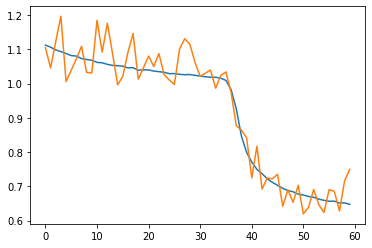

In [127]:
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")

plt.show()

### Preprocessing singal and bkgd from all the decaymodes

In [54]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
    for decaymode in tqdm(decaymodes):
        points = []
        args.Z_FRACTION = 1.0
        args.IN = '/home/anderson/higgs_data/'+decaymode
        args.TYPE = 'nn_'+decaymode
        args.LABEL = False
        data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
        event = eval(events[args.TYPE])(data, args)
        points.append(EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED))
        pickle.dump(points,open(args.IN+'/events_w_background_test.pk','wb'))
        break

  0%|          | 0/3 [00:00<?, ?it/s]

Loading data
Read 1000000 events
Events including background: 2000000
SCALE!!


## Loading bkgd samples

In [141]:
background_points=pickle.load(open(args.IN+'/events_w_background_test.pk','rb'))

In [142]:
particle_idx = 0 # 0 for rhorho
background=[]
background.append(background_points[particle_idx].train.x[background_points[particle_idx].train.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].valid.x[background_points[particle_idx].valid.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].test.x[background_points[particle_idx].test.weights.sum(axis=1)==0])

In [143]:
background=np.concatenate(background)

In [144]:
background=torch.tensor(background).float().to(device)

### Testing NN w/ bkgd only

In [169]:
model.load_state_dict(torch.load('model/best_model_59.pt'))
model.eval()
with torch.no_grad():
    outputs=[]
    # change range of sample using for testing
    for i in tqdm(range(500000, 1000000,batch_size)):
        outputs.append(model(background[i:i+batch_size]).detach().cpu())
outputs=torch.cat(outputs)

bg_outputs=torch.argmax(torch.softmax(outputs,axis=1),axis=1).numpy()
bg_labels_counts=np.unique(bg_outputs,return_counts=True)[1]

  0%|          | 0/977 [00:00<?, ?it/s]

In [170]:
pickle.dump(bg_outputs,open(args.IN+'/NN_outputs_background_only.pk','wb'))

### Testing NN w/ signal only (Class 0)

In [171]:
model.load_state_dict(torch.load('model/best_model_59.pt'))
model.eval()
with torch.no_grad():
    signal_outputs,signal_labels=[],[]
    for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader):
        signal_outputs.append(model(rhorho_s).detach().cpu())
        signal_labels.append(label_s.detach().cpu())
signal_outputs=torch.softmax(torch.cat(signal_outputs),axis=1).numpy()
signal_labels=np.concatenate(signal_labels)
####### Filtering signal outputs that are classified to Class 0
signal_outputs=signal_outputs[np.argmax(signal_labels,axis=1)==0]
signal_labels=np.argmax(signal_outputs,axis=1)

In [172]:
pickle.dump(signal_outputs,open(args.IN+'/NN_outputs_signal_only.pk','wb'))

### Test Results

In [173]:
bg_outputs = pickle.load(open(args.IN+'/NN_outputs_background_only.pk','rb'))
signal_outputs= pickle.load(open(args.IN+'/NN_outputs_signal_only.pk','rb'))

In [174]:
#plt.fill_between(np.arange(args.NUM_CLASSES-1),0,bg_labels_counts,alpha=1,hatch='/', facecolor="skyblue")
#plt.fill_between(np.arange(args.NUM_CLASSES-1),bg_labels_counts,bg_labels_counts+signal_labels_counts,color='red',alpha=1)
#plt.fill_between(np.arange(args.NUM_CLASSES-1),outputs.mean(axis=0)[:args.NUM_CLASSES-1],outputs.mean(axis=0)[:args.NUM_CLASSES-1]+signal_outputs[np.argmax(signal_labels,axis=1)==0].mean(axis=0)[:args.NUM_CLASSES-1],color='red',alpha=1)

In [175]:
# create the dataframe; enumerate is used to make column names
#columns=['Ztt','Signal']
#fig,ax=plt.subplots(dpi=150)
#plt.xlabel("Classes")
#lt.ylabel("Events")
#df = pd.concat([pd.DataFrame(a, columns=[columns[i]]) for i, a in enumerate([bg_outputs, np.argmax(signal_outputs,axis=1)], 0)], axis=1)

# plot the data
#ax.set_xlim(0,args.NUM_CLASSES-2)
#ax = df.plot.hist(stacked=True, bins=args.NUM_CLASSES-1,ax=ax, color = ['skyblue','red']).get_figure()
# ax.set_xticks(np.arange(args.NUM_CLASSES-2))
# ax.set_xticklabels((np.linspace(0,2,args.NUM_CLASSES-2)*np.pi))
# bars = ax.patches
# hatches = ['/','\\']

# for i in range(2):
#     for j in range(args.NUM_CLASSES-1):
#         bars[i*(args.NUM_CLASSES-1)+j].set_hatch(hatches[i])

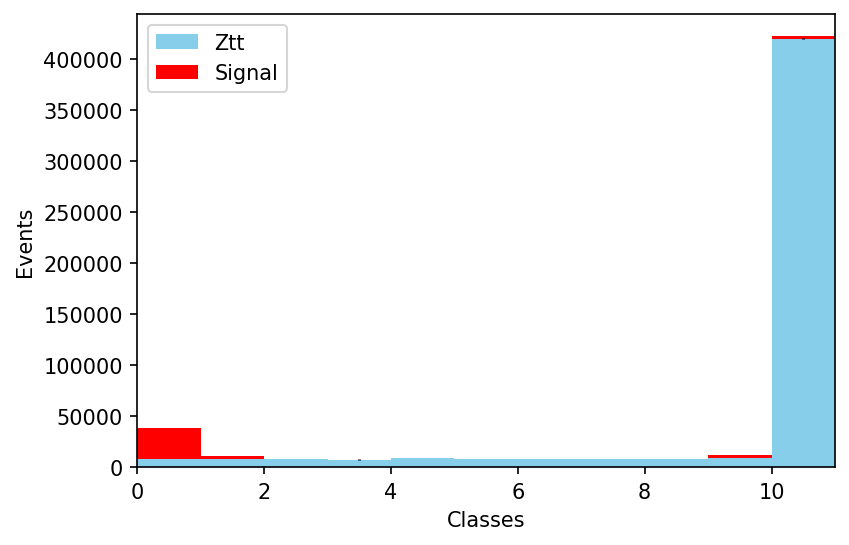

In [176]:
fig,ax=plt.subplots(dpi=150)

Ztt = bg_outputs
Signal = np.array(np.argmax(signal_outputs,axis=1))

plt.xlabel("Classes")
plt.ylabel("Events")

# plot the data
bins = args.NUM_CLASSES
ax.set_xlim(0,bins)
entries, edges, _ = plt.hist([Ztt,Signal], bins, color = ['skyblue', 'red'], stacked=True, label=['Ztt','Signal'])

ax.legend()

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw error bars
Ztt_std = np.sqrt(entries[0])
plt.errorbar(bin_centers, entries[0], yerr=Ztt_std, ls='none', ecolor='black')

plt.show()

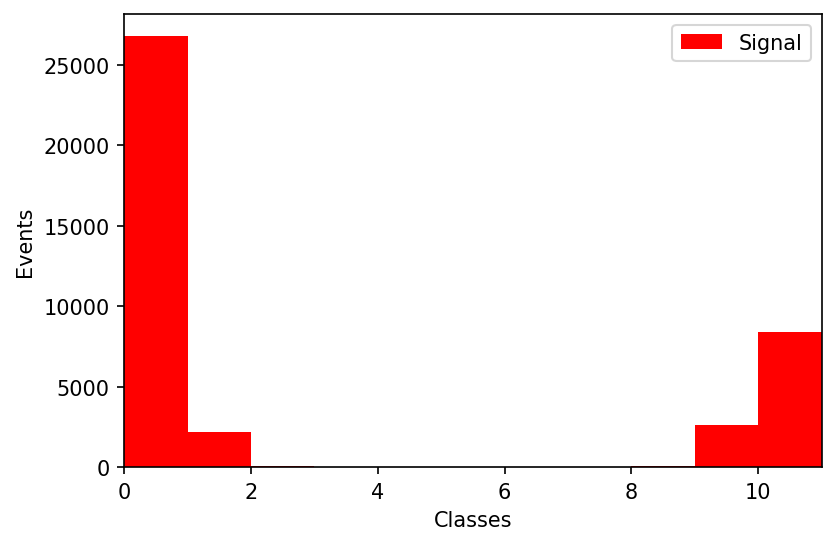

In [70]:
fig,ax=plt.subplots(dpi=150)

Ztt = bg_outputs
Signal = np.array(np.argmax(signal_outputs,axis=1))

plt.xlabel("Classes")
plt.ylabel("Events")

# plot the data
bins = args.NUM_CLASSES
ax.set_xlim(0,bins)
#entries, edges, _ = plt.hist(Ztt, bins, color = 'skyblue', label='Ztt')
entries, edges, _ = plt.hist(Signal, bins, color = 'red', label='Signal')

ax.legend()

# calculate bin centers
#bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw error bars
#Ztt_std = np.sqrt(entries)
#plt.errorbar(bin_centers, entries, yerr=Ztt_std, ls='none', ecolor='black')

plt.show()

In [71]:
np.set_printoptions(suppress=True)
print(entries)

[26802.  2186.    66.    12.     9.     9.     9.    11.    38.  2586.
  8391.]


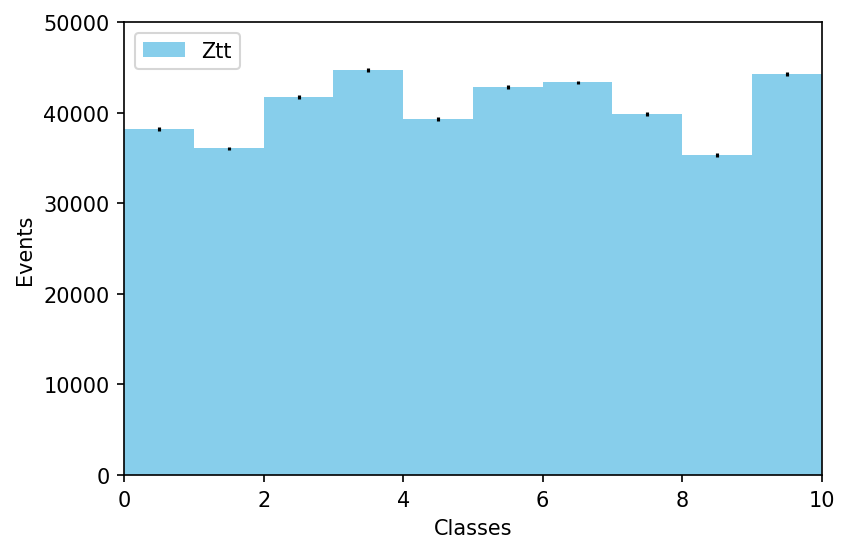

In [76]:
fig,ax=plt.subplots(dpi=150)

Ztt = bg_outputs
Signal = np.array(np.argmax(signal_outputs,axis=1))

plt.xlabel("Classes")
plt.ylabel("Events")

# plot the data
bins = args.NUM_CLASSES
#ax.set_xlim(0,bins)
ax.set_xlim(0,bins-1) # show classes 0-10 only
ax.set_ylim(0,50000)
entries, edges, _ = plt.hist(Ztt, bins, color = 'skyblue', label='Ztt')
#entries, edges, _ = plt.hist(Signal, bins, color = 'red', label='Signal')

ax.legend()

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw error bars
Ztt_std = np.sqrt(entries)
plt.errorbar(bin_centers, entries, yerr=Ztt_std, ls='none', ecolor='black')

plt.show()

In [73]:
print(entries)
entries.sum()

[38220. 36067. 41751. 44706. 39335. 42864. 43332. 39871. 35339. 44311.
 94204.]


500000.0